In [5]:
# Generales
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pydot as pyd
import time
import joblib

# image preprocessing
import os
import sys
import shutil
import glob
import matplotlib.image as mpimg
from PIL import Image

# clustimage
from clustimage import Clustimage

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, jaccard_score,\
                            f1_score, precision_recall_curve,\
                            confusion_matrix, ConfusionMatrixDisplay,\
                            silhouette_score, mutual_info_score

# My packages
from tools import show_results_frecuencies as show_results

In [6]:
# Constants

# dirs
inp_img_dir = "./samples/"
out_dir = ""

# init
start_num = 1

height, width = 32, 32

# placeholder
r = "rule_"

# Classes
class1 = [0, 255,
        8, 64, 239, 253,
        32, 251,
        40, 96, 235, 249,
        128, 254,
        136, 192, 238, 252,
        160, 250,
        168, 224, 234, 248]

class2 = [1, 127,
        2, 16, 191, 247,
        3, 17, 63, 119,
        4, 223,
        5, 95,
        6, 20, 159, 215,
        7, 21, 31, 87,
        9, 65, 111, 125,
        10, 80, 175, 245,
        11, 47, 81, 117,
        12, 68, 207, 221,
        13, 69, 79, 93,
        14, 84, 143, 213,
        15, 85,
        19, 55,
        23,
        24, 66, 189, 231,
        25, 61, 67, 103,
        26, 82, 167, 181,
        27, 39, 53, 83,
        28, 70, 157, 199,
        29, 71,
        33, 123,
        34, 48, 187, 243,
        35, 49, 59, 115,
        36, 219,
        37, 91,
        38, 52, 155, 211,
        42, 112, 171, 241,
        43, 113,
        44, 100, 203, 217,
        46, 116, 139, 209,
        50, 179,
        51,
        56, 98, 185, 227,
        57, 99,
        58, 114, 163, 177,
        62, 118, 131, 145,
        72, 237,
        73, 109,
        74, 88, 173, 229,
        76, 205,
        77,
        78, 92, 141, 197,
        94, 133,
        104, 233,
        108, 201,
        130, 144, 190, 246,
        132, 222,
        134, 148, 158, 214,
        138, 174, 208, 224,
        140, 196, 206, 220,
        142, 212,
        152, 188, 194, 230,
        154, 166, 180, 210,
        156, 198,
        162, 176, 186, 242,
        164, 218,
        170, 240,
        172, 202, 216, 228,
        178,
        184, 226,
        200, 236,
        204,
        232]
class3 = [18, 183,
        22, 151,
        30, 86, 135, 149,
        45, 75, 89, 101,
        60, 102, 153, 195,
        90, 165,
        105,
        122, 161,
        126, 129,
        146, 182,
        150]
class4 = [41, 97, 107, 121,
        54, 147,
        106, 120, 169, 225,
        110, 124, 137, 193]

total images per class
- c1: 49364
- c2: 51007
- c3: 46550
- c4: 46559

In [7]:
def getPics(class_rules, samples_dir, n_samples_per_rule=None):
    class_imgs = []

    for r in class_rules:
        imgs_dir = samples_dir + f'rule_{str(r)}/'
        imgs_temp = [imgs_dir + f for f in os.listdir(imgs_dir)]
        class_imgs += imgs_temp[:n_samples_per_rule] # class balancing
    return class_imgs

c1_img_list = getPics(class1, inp_img_dir, 52)
c2_img_list = getPics(class2, inp_img_dir, 6)
c3_img_list = getPics(class3, inp_img_dir, 48)
c4_img_list = getPics(class4, inp_img_dir, 89)

files_target = [np.full(len(c1_img_list), 1), 
                np.full(len(c2_img_list), 2), 
                np.full(len(c3_img_list), 3), 
                np.full(len(c4_img_list), 4)]
[x.shape[0] for x in files_target]

[1248, 1152, 1248, 1246]

In [8]:
# Data selection

c1_x = c1_img_list.copy()
c2_x = c2_img_list.copy()
c3_x = c3_img_list.copy()
c4_x = c4_img_list.copy()

c1_y = files_target[0].copy()
c2_y = files_target[1].copy()
c3_y = files_target[2].copy()
c4_y = files_target[3].copy()

c_x = np.array(c1_x+c2_x+c3_x+c4_x)
c_y = np.concatenate((c1_y,c2_y,c3_y,c4_y))

In [9]:
dataset = pd.DataFrame({'img':c_x, 'class':c_y})
dataset = dataset.sample(frac=1)
print(dataset.shape)
dataset.head(3)

(4894, 2)


,img,class
3206,./samples/rule_90/90_000_0205_9893.png,3
353,./samples/rule_32/32_000_0252_4017.png,1
4724,./samples/rule_137/137_000_0018_5455.png,4


In [10]:
# Assert total representation of classes
dataset.img.apply(lambda x: x.split('/')[2]).nunique()

255

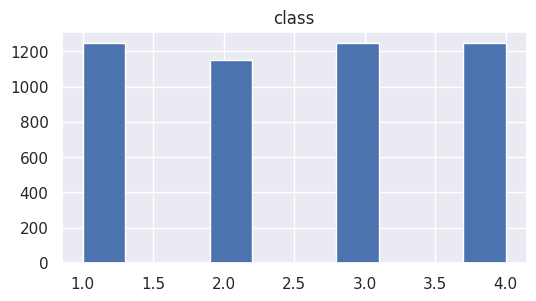

In [11]:
dataset.hist(figsize=(6,3))
plt.show()

In [12]:
cl_pca = Clustimage(method='pca',
                    params_pca={'n_components': 0.95,
                                'random_state': 42})

In [13]:
# clustimage object parameters

cluster='dbscan'
evaluate='silhouette'
metric='euclidean'
linkage='ward'
min_clust=3
max_clust=6
cluster_space='low'

In [14]:
results = cl_pca.fit_transform(dataset['img'].values,
                               cluster=cluster,
                               evaluate=evaluate,
                               metric=metric,
                               linkage=linkage,
                               min_clust=min_clust,
                               max_clust=max_clust,
                               cluster_space=cluster_space)

[clustimage] >INFO> Cleaning previous fitted model results
[clustimage] >INFO> Reading and checking images.
[clustimage] >INFO> Reading and checking images.
100%|██████████| 4894/4894 [00:03<00:00, 1612.87it/s]
[clustimage] >INFO> Extracting features using method: [pca]


[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [49152] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [646] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [49152] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Extracted features using [pca]: samples=4894, features=646
[clustimage] >INFO> Compute [tsne] embedding
[clustimage] >INFO> Cluster evaluation using the [low] feature space of the [tsne] coordinates.



[clusteval] >Fit using dbscan with metric: euclidean, and linkage: ward
[clusteval] >Gridsearch across epsilon..
[clusteval] >Evaluate using silhouette..


100%|██████████| 245/245 [02:00<00:00,  2.03it/s]
[clustimage] >INFO> Updating cluster-labels and cluster-model based on the (4894, 2) feature-space.


[clusteval] >Compute dendrogram threshold.
[clusteval] >Optimal number clusters detected: [3].
[clusteval] >Fin.


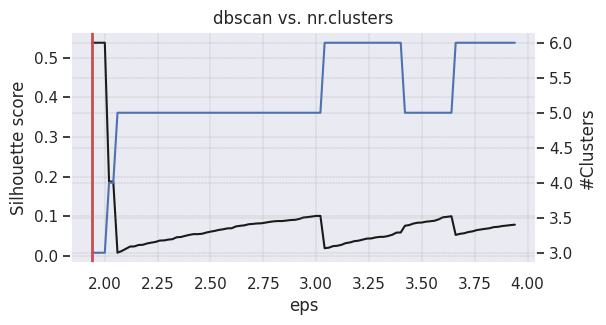

(<Figure size 600x300 with 2 Axes>,
 (<Axes: title={'center': 'dbscan vs. nr.clusters'}, xlabel='eps', ylabel='Silhouette score'>,
  <Axes: ylabel='#Clusters'>))

In [15]:
# Silhouette plots
cl_pca.clusteval.plot(figsize=(6,3))

[clusteval] >Estimated number of n_clusters: 2, average silhouette_score=0.538


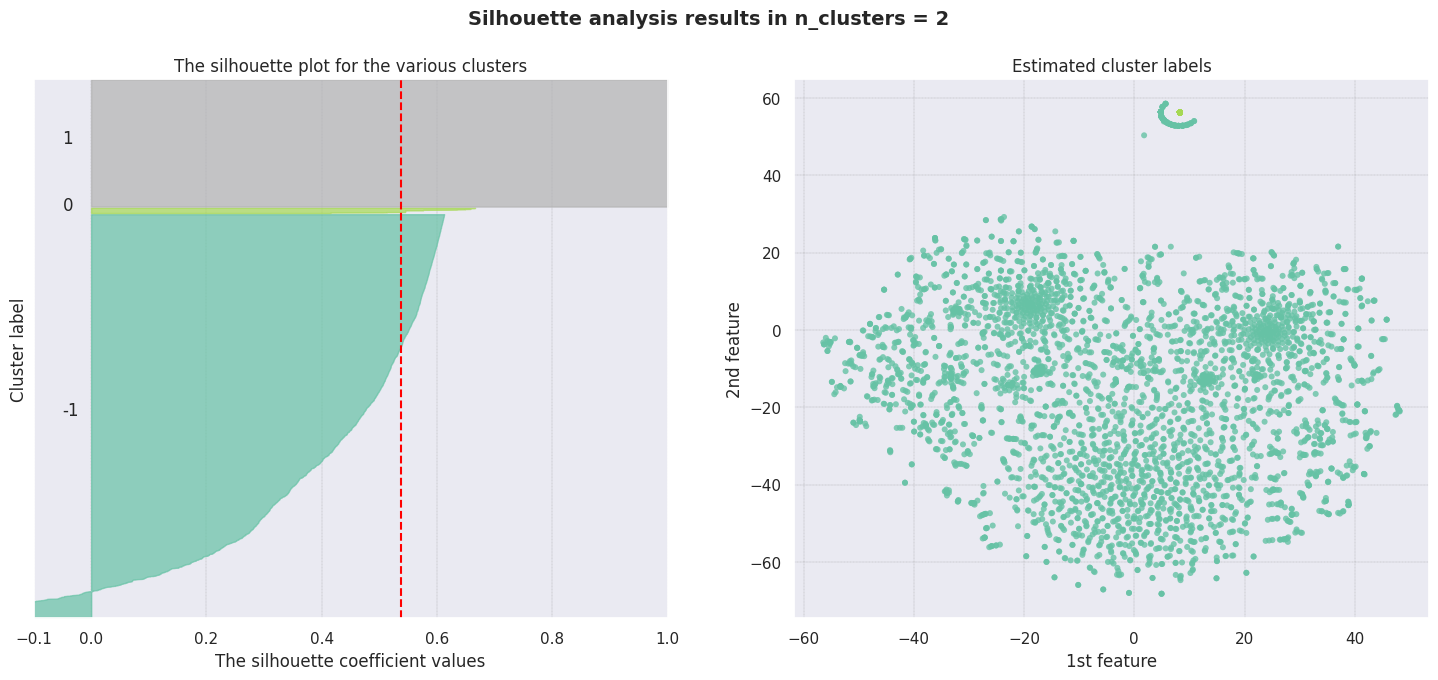

(<Figure size 1800x700 with 2 Axes>,
 <Axes: title={'center': 'The silhouette plot for the various clusters'}, xlabel='The silhouette coefficient values', ylabel='Cluster label'>,
 <Axes: title={'center': 'Estimated cluster labels'}, xlabel='1st feature', ylabel='2nd feature'>)

In [16]:
cl_pca.clusteval.scatter(cl_pca.results['xycoord'], figsize=(6,3))

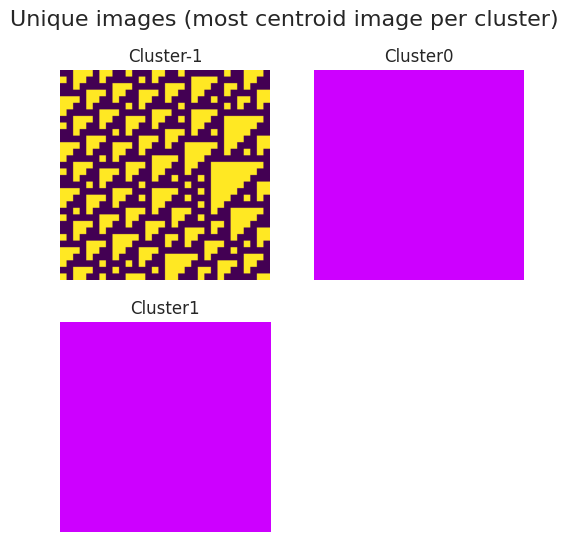

In [17]:
# Plot unique image per cluster
cl_pca.plot_unique(img_mean=False, figsize=(6,6))

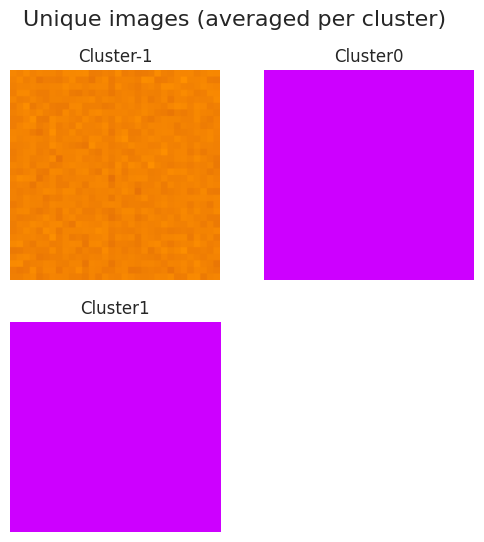

In [18]:
# Plot unique image per cluster
cl_pca.plot_unique(figsize=(6,6))

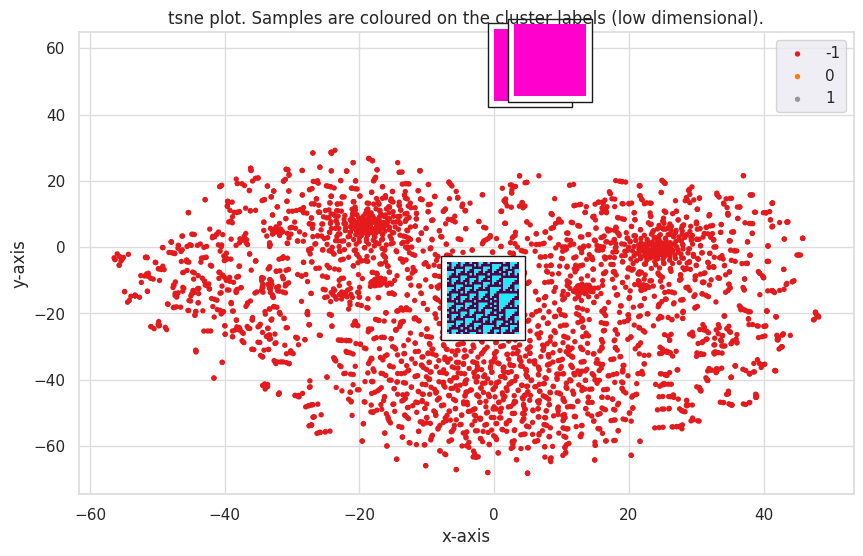

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'tsne plot. Samples are coloured on the cluster labels (low dimensional).'}, xlabel='x-axis', ylabel='y-axis'>)

<Figure size 640x480 with 0 Axes>

In [19]:
# Scatterplot
cl_pca.scatter(zoom=0.4, img_mean=False, figsize=(10,6))

# Results

In [20]:
names, labels = cl_pca.results['pathnames'],\
                cl_pca.results['labels']

results_df = pd.DataFrame(data={'img':names,
                                'y_pred':labels})
results_df.head(3)

,img,y_pred
0,./samples/rule_90/90_000_0205_9893.png,0
1,./samples/rule_32/32_000_0252_4017.png,-1
2,./samples/rule_137/137_000_0018_5455.png,-1


In [21]:
save_path = './results/'

file_name = f'all_imgs_{cluster}_{evaluate}_{metric}.csv'

results_df.to_csv(save_path + file_name, index=False)

In [22]:
np.unique(c_y), np.unique(labels)

(array([1, 2, 3, 4]), array([-1,  0,  1]))

In [23]:
scores = {
    'accuracy_score' : {
        'results': accuracy_score(c_y, labels)
    },
    'jaccard_score':{
        'results':jaccard_score(c_y, labels, average="micro")
    },
    'f1_score':{
        'results': f1_score(c_y, labels, average='micro')
    },
    'mutual_info_score':{
        'results': mutual_info_score(c_y, labels)
    },
    
}

results_df = pd.DataFrame.from_dict(scores)
results_df.T

,results
accuracy_score,0.046179
jaccard_score,0.023635
f1_score,0.046179
mutual_info_score,0.016394


In [24]:
n_classes = len(np.unique(labels))
show_results(labels, n_classes, 'y_train', 10)